# 

# Closed-Loop Simulation with SHARPy as a hardware-in-the-loop system

This tutorial examplifies theapplication of an arbitary controller on a nonlinear aeroelastic problem using SHARPy as a hardware-in-the-loop system. The objective is to introduce the reader to SHARPy's capablities of applying controller on nonlinear aeroservoelastic problems. Here, we intend to use a P-controller to reduce gust-induced wingtip displacements as a simple and quick example. After, the reader should have all they need to design and test more advanced controller on nonlinear aeroelastic problems.

This controller receives sensor measurements from SHARPy using an UDP-interface and generates a control input. This input is fed back to the actuators incorporated in SHARPy again through the UDP-interface. 



The notebook is structured such that first, we design the model and its operational point. Second, the model is linearized and reduced. The resulting reduced-order model (ROM) can then be used for an efficient control design. Third, we apply via an UDP-Interface the designed controller on a nonlinear aeroelastic simulation performed with SHARPy.


Please note that this notebook requires ?? hours to be completed.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sharpy.cases.templates.flying_wings as wings
import sharpy.sharpy_main
import json

TODO:
* References
* postprocessing
* Gather all imported ilbraries at one place (for debugging)

## Demonstrator Model 

The very-flexible Pazy wing serves as demonstrator model and an aileron located near the wingtip as an actuator. The objective in this example is to alleviate the wingtip displacement due to gust-induced wing loads. As an example, we use a P-controller implemented in a Python interface with the objective to reduce the wingtip displacement induced by a gust encounter.

However, the reader can test any controller run on any platform as long as a working UDP connection to SHARPy can be established. 



### Setup
We start by defining the exact operational setup of the problem case. Reference velocity and angle of attack are chosen to avoid flutter as observable in [2].

In [3]:
u_inf = 40 # m/s
alpha_deg = 1
rho = 1.225

Next, we define the lattice grid discretisation of the wing and wake

In [4]:
number_chordwise_panels = 8
number_spanwise_nodes = 32
wake_length_factor = 10

as well as simulation settings

In [5]:
num_cores = 2
simulation_time = 2.

and define the folder into which SHARPy input files (cases) are written and an output folder which will include all generated simulation results.

In [41]:
cases_folder = './cases/'
output_folder = './output'
route_notebook_dir =  os.path.abspath('')

### Open-Loop Gust Response
After, defining the general settings, we now simulate the open-loop response of the Pazy wing to a gust. First, we generateinput files for the Pazy model aerodynamic and structural properties, giving the above defined flight conditions, discretisation, and simulation settings.

In [13]:

case_name = 'pazy_open_loop_gust_response'
pazy_model_open_loop = wings.PazyControlSurface(M=number_chordwise_panels,
                                      N=number_spanwise_nodes,
                                      Mstar_fact=wake_length_factor,
                                      u_inf=u_inf,
                                      alpha=alpha_deg,
                                      rho=rho,
                                      n_surfaces=2,
                                      route=cases_folder + '/' + case_name,
                                      case_name=case_name,
                                      physical_time=simulation_time,)


In [14]:
def generate_aero_and_fem_input_files(model):
    model.clean_test_files()
    model.update_derived_params()
    model.generate_aero_file()
    model.generate_fem_file()
    
generate_aero_and_fem_input_files(pazy_model_open_loop)

Next, we define the gust shape used, i.e. a 1-cosine gust with a gust length $10\,m$ and intensity of $2\,\%$

In [15]:
gust = True
gust_settings  ={'gust_shape': '1-cos',
                'gust_length': 10.,
                'gust_intensity': 0.02,
                'gust_offset': 0.}  

In [16]:
flow = ['BeamLoader',
        'AerogridLoader',
        'StaticCoupled',
        'AerogridPlot',
        'BeamPlot',
        'DynamicCoupled',
        ]
from get_settings_udp import get_settings_udp

pazy_model_open_loop.set_default_config_dict()
pazy_model_open_loop.config = get_settings_udp(pazy_model_open_loop,
                            flow,
                            num_cores=num_cores,
                            wake_length_factor=wake_length_factor,
                            output_folder = output_folder,
                            gust=gust,
                            gust_settings=gust_settings)
pazy_model_open_loop.config.write()

In [17]:

sharpy.sharpy_main.main(['', pazy_model_open_loop.route + pazy_model_open_loop.case_name + '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/sduess/Documents/SHARPY_simulations/body-freedom_flutter_analysis/lib/sharpy/docs/source/content/example_notebooks/UDP_control
SHARPy being run is in /home/sdue

fatal: not a git repository (or any of the parent directories): .git


|  0  |  0  |  0.00000   | -0.0273  |  0.0000  |  1.8901  |  0.0000  |  0.0383  | -0.0000  |
|  1  |  0  |  -6.74656  | -0.0285  |  0.0000  |  1.9338  |  0.0000  |  0.0392  |  0.0000  |
|  0  |  1  |  0.00000   | -0.0556  |  0.0000  |  3.8796  |  0.0000  |  0.0785  | -0.0000  |
|  1  |  1  |  -6.11626  | -0.0581  |  0.0000  |  3.9695  |  0.0000  |  0.0803  | -0.0000  |
|  0  |  2  |  0.00000   | -0.0850  |  0.0000  |  5.9765  | -0.0000  |  0.1208  | -0.0000  |
|  1  |  2  |  -5.73462  | -0.0889  |  0.0000  |  6.1159  | -0.0000  |  0.1236  | -0.0000  |
|  0  |  3  |  0.00000   | -0.1156  |  0.0000  |  8.1900  | -0.0000  |  0.1653  | -0.0000  |
|  1  |  3  |  -5.45408  | -0.1209  |  0.0000  |  8.3823  | -0.0000  |  0.1691  | -0.0000  |
|  0  |  4  |  0.00000   | -0.1473  |  0.0000  | 10.5298  | -0.0000  |  0.2123  | -0.0000  |
|  1  |  4  |  -5.22841  | -0.1541  |  0.0000  | 10.7788  | -0.0000  |  0.2172  | -0.0000  |
Generating an instance of AerogridPlot
Variable include_forward_motion

|   1   | 0.0003 |  5   |   0.890256   |  10.693952   |  -6.455443   | 0.000000e+00 | 0.000000e+00 |
|   2   | 0.0006 |  4   |   0.879143   |   7.945449   |  -6.388404   | 0.000000e+00 | 0.000000e+00 |


KeyboardInterrupt: 

#### Gust-induced Tip Deflection

Paraview video and plot

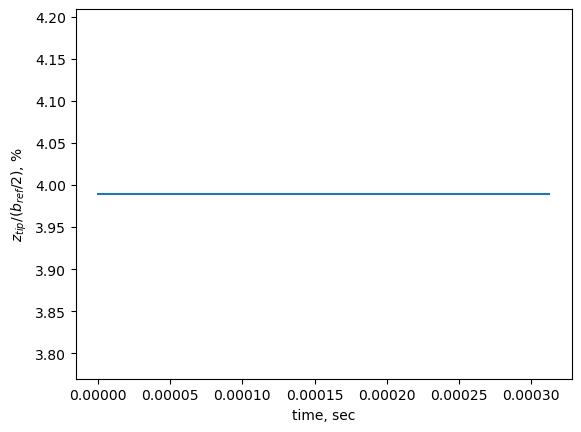

In [34]:

def get_resulting_vertical_tip_displacement(output_folder, model):    
    file_results = os.path.join(output_folder, 
                                 model.case_name, 
                                 'WriteVariablesTime',
                                 'struct_pos_node{}.dat'.format(model.num_node_surf))
    vertical_tip_displacement = np.loadtxt(file_results)[:,-1]
    
                                             
    return vertical_tip_displacement


tip_displacement_open_loop = get_resulting_vertical_tip_displacement(output_folder, 
                                                                     pazy_model_open_loop)


time_array = np.arange(0, len(tip_displacement_open_loop) * pazy_model_open_loop.dt, pazy_model_open_loop.dt)
normalised_tip_displacement = tip_displacement_open_loop/ (0.5*pazy_model_open_loop.b_ref) #normalise by half wing span
normalised_tip_displacement *=100# cconvert to percentnvert to percent
plt.plot(time_array, normalised_tip_displacement)
plt.xlabel('time, sec')
plt.ylabel('$z_{tip}/(b_{ref}/2)$, %')
plt.show()

## Generate ROM

In [18]:
case_name = 'pazy_ROM'
simulation_time_ROM = pazy_model_open_loop.dt # only one timestep has to be performed
gust = False

In [19]:
flow = ['BeamLoader',
        'AerogridLoader',
        'StaticCoupled',
        'DynamicCoupled',
        'Modal',
        'LinearAssembler',
        'SaveData',
        ]


In [20]:
pazy_model_ROM = wings.PazyControlSurface(M=number_chordwise_panels,
                                      N=number_spanwise_nodes,
                                      Mstar_fact=wake_length_factor,
                                      u_inf=u_inf,
                                      alpha=alpha_deg,
                                      rho=rho,
                                      n_surfaces=2,
                                      route=cases_folder + '/' + case_name,
                                      case_name=case_name,
                                      physical_time=simulation_time_ROM,)

generate_aero_and_fem_input_files(pazy_model_ROM)


In [21]:
use_rom = True
rom_settings = {
    'use': use_rom,
    'rom_method': 'Krylov',
    'rom_method_settings': {'Krylov': {
                                        'algorithm': 'mimo_rational_arnoldi',
                                        'r': 4, 
                                        'frequency': np.array([0]),
                                        'single_side': 'observability',
                                        },
                           }
                }

In [22]:
num_modes = 20
unsteady_force_distribution = False
remove_gust_input_in_statespace=False

In [23]:
pazy_model_ROM.set_default_config_dict()
pazy_model_ROM.config = get_settings_udp(pazy_model_ROM,
                            flow,
                            num_cores=num_cores,
                            wake_length_factor=wake_length_factor,
                            output_folder = output_folder,
                            gust=gust,
                            gust_settings=gust_settings,
                            num_modes = num_modes,
                            rom_settings = rom_settings,
                            remove_gust_input_in_statespace=remove_gust_input_in_statespace,
                            unsteady_force_distribution=unsteady_force_distribution)
pazy_model_ROM.config.write()

In [24]:

sharpy.sharpy_main.main(['', pazy_model_ROM.route + pazy_model_ROM.case_name + '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/sduess/Documents/SHARPY_simulations/body-freedom_flutter_analysis/lib/sharpy/docs/source/content/example_notebooks/UDP_control
SHARPy being run is in /home/sdue

fatal: not a git repository (or any of the parent directories): .git


|  0  |  0  |  0.00000   | -0.0273  |  0.0000  |  1.8901  |  0.0000  |  0.0383  | -0.0000  |
|  1  |  0  |  -6.74656  | -0.0285  |  0.0000  |  1.9338  |  0.0000  |  0.0392  |  0.0000  |
|  0  |  1  |  0.00000   | -0.0556  |  0.0000  |  3.8796  |  0.0000  |  0.0785  | -0.0000  |
|  1  |  1  |  -6.11626  | -0.0581  |  0.0000  |  3.9695  |  0.0000  |  0.0803  | -0.0000  |
|  0  |  2  |  0.00000   | -0.0850  |  0.0000  |  5.9765  | -0.0000  |  0.1208  | -0.0000  |
|  1  |  2  |  -5.73462  | -0.0889  |  0.0000  |  6.1159  | -0.0000  |  0.1236  | -0.0000  |
|  0  |  3  |  0.00000   | -0.1156  |  0.0000  |  8.1900  | -0.0000  |  0.1653  | -0.0000  |
|  1  |  3  |  -5.45408  | -0.1209  |  0.0000  |  8.3823  | -0.0000  |  0.1691  | -0.0000  |
|  0  |  4  |  0.00000   | -0.1473  |  0.0000  | 10.5298  | -0.0000  |  0.2123  | -0.0000  |
|  1  |  4  |  -5.22841  | -0.1541  |  0.0000  | 10.7788  | -0.0000  |  0.2172  | -0.0000  |
Generating an instance of DynamicCoupled
Variable controller_id has no

|      0       |   0.000000   |  29.975304   |   4.770718   |   4.770718   |  -0.000000   |   0.209612   |
|      1       |   0.000000   |  29.976393   |   4.770891   |   4.770891   |  -0.000000   |   0.209604   |
|      2       |   0.000000   |  188.884114  |  30.061840   |  30.061840   |  -0.000000   |   0.033265   |
|      3       |   0.000000   |  188.885266  |  30.062024   |  30.062024   |  -0.000000   |   0.033265   |
|      4       |   0.000000   |  262.521332  |  41.781568   |  41.781568   |  -0.000000   |   0.023934   |
|      5       |   0.000000   |  262.526456  |  41.782383   |  41.782383   |  -0.000000   |   0.023934   |
|      6       |   0.000000   |  527.154876  |  83.899304   |  83.899304   |  -0.000000   |   0.011919   |
|      7       |   0.000000   |  527.155960  |  83.899477   |  83.899477   |  -0.000000   |   0.011919   |
|      8       |   0.000000   |  671.524022  |  106.876367  |  106.876367  |  -0.000000   |   0.009357   |
|      9       |   0.000000   |  671.

Generating an instance of LinearBeam
Variable use_euler has no assigned value in the settings file.
    will default to the value: True
Variable remove_sym_modes has no assigned value in the settings file.
    will default to the value: False
Variable remove_rigid_states has no assigned value in the settings file.
    will default to the value: False
Warning, projecting system with damping onto undamped modes


/home/sduess/anaconda3/envs/sharpy/lib/python3.10/site-packages/sharpy/linear/src/lingebm.py:313: UserWarning: Euler parametrisation not implemented - Either rigid body modes are not being used or this method has already been called.
  warnings.warn('Euler parametrisation not implemented - Either rigid body modes are not being used or this '



Linearising gravity terms...
	M = 0.00 kg
	X_CG A -> -0.26 0.17 0.00
Node  1 	-> B -0.000 -0.000 -0.000
			-> A 0.000 0.034 0.000
			-> G 0.000 0.034 0.000
	Node mass:
		Matrix: 0.0202
Node  2 	-> B -0.000 -0.000 -0.000
			-> A 0.000 0.069 0.001
			-> G 0.000 0.069 0.001
	Node mass:
		Matrix: 0.0101
Node  3 	-> B -0.000 -0.000 -0.000
			-> A 0.000 0.103 0.001
			-> G 0.000 0.103 0.001
	Node mass:
		Matrix: 0.0202
Node  4 	-> B -0.000 -0.000 -0.000
			-> A 0.000 0.137 0.002
			-> G 0.000 0.137 0.002
	Node mass:
		Matrix: 0.0101
Node  5 	-> B -0.000 -0.000 -0.000
			-> A 0.000 0.172 0.004
			-> G 0.000 0.172 0.004
	Node mass:
		Matrix: 0.0202
Node  6 	-> B -0.000 -0.000 -0.000
			-> A 0.000 0.206 0.005
			-> G 0.000 0.206 0.005
	Node mass:
		Matrix: 0.0101
Node  7 	-> B -0.000 -0.000 -0.000
			-> A 0.000 0.241 0.006
			-> G 0.000 0.241 0.006
	Node mass:
		Matrix: 0.0202
Node  8 	-> B -0.000 -0.000 -0.000
			-> A 0.000 0.275 0.008
			-> G 0.000 0.275 0.008
	Node mass:
		Matrix: 0.0101
No

FINISHED - Elapsed time = 34.6325286 seconds
FINISHED - CPU process time = 337.5779396 seconds


Postprocessing:
- linear gust response
- control design

## Closed-Loop Nonlinear Gust Response

In [25]:
case_name = 'pazy_udp_closed_loop_gust_response'
gust = True
flow = ['BeamLoader',
        'AerogridLoader',
        'StaticCoupled',
        'DynamicCoupled',
        ]

In [26]:
initial_cs_deflection = 0
cs_type = 2 


In [27]:
pazy_model_closed = wings.PazyControlSurface(M=number_chordwise_panels,
                                      N=number_spanwise_nodes,
                                      Mstar_fact=wake_length_factor,
                                      u_inf=u_inf,
                                      alpha=alpha_deg,
                                      initial_cs_deflection=initial_cs_deflection,
                                      rho=rho,
                                      n_surfaces=2,
                                      route=cases_folder + '/' + case_name,
                                      case_name=case_name,
                                      physical_time=simulation_time,
                                      cs_type=cs_type)
generate_aero_and_fem_input_files(pazy_model_closed)

In [42]:
#  Network settings for nonlinear in closed-loop simulations   
server_ip_addr = '127.0.0.1' # SHARPy
client_ip_addr = '127.0.0.1' # controller
port_in_network = 64019    
port_out_network_server = 59019
port_out_network_client = 59009        
network_settings = {'variables_filename': route_notebook_dir + '/pazy_network_info.yml', # TODO: explain in text
                                        'send_output_to_all_clients': False,
                                        'byte_ordering': 'little',
                                        'log_name': output_folder +'/'+ case_name + '/sharpy_network.log',
                                        'file_log_level': 'debug',
                                        'console_log_level': 'debug',
                                        'input_network_settings': {'address': server_ip_addr,
                                                                        'port': port_in_network,
                                                                        },
                                        'output_network_settings': {'send_on_demand': False,
                                                                        'port': port_out_network_server,
                                                                        'address':server_ip_addr, 
                                                                        'destination_address': [client_ip_addr],
                                                                        'destination_ports': [port_out_network_client],
                                                                }
                                                }



In [43]:
num_sensors = 1

In [44]:
pazy_model_closed.set_default_config_dict()
pazy_model_closed.config = get_settings_udp(pazy_model_closed,
                            flow,
                            network_settings=network_settings,
                            num_cores=num_cores,
                            wake_length_factor=wake_length_factor,
                            output_folder = output_folder,
                            gust=gust,
                            gust_settings=gust_settings)
pazy_model_closed.config.write()

Start simulation and controller and UDP-interface,
write necessary parameters to file

In [45]:
dict_parameters = {"server_ip_addr": server_ip_addr,
                   "client_ip_addr": client_ip_addr,
                   "port_in_network": port_in_network,
                   "port_out_network_server": port_out_network_server,
                   "port_out_network_client": port_out_network_client,
                   "output_folder": os.path.abspath(output_folder),
                   "dt": pazy_model_closed.dt,
                   "simulation_time": simulation_time,
                   "num_sensors": num_sensors,
                   "initial_cs_deflection": initial_cs_deflection,
                   "reference_deflection": tip_displacement_open_loop[0],
                  }
with open('./parameter_UDP_control_{}.json'.format(pazy_model_closed.case_name), 'w') as fp:
    json.dump(dict_parameters, fp)

In [ ]:
sharpy.sharpy_main.main(['', pazy_model_closed.route + pazy_model_closed.case_name + '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/sduess/Documents/SHARPY_simulations/body-freedom_flutter_analysis/lib/sharpy/docs/source/content/example_notebooks/UDP_control
SHARPy being run is in /home/sdue

fatal: not a git repository (or any of the parent directories): .git


|  0  |  0  |  0.00000   | -0.0273  |  0.0000  |  1.8901  |  0.0000  |  0.0383  | -0.0000  |
|  1  |  0  |  -6.74656  | -0.0285  |  0.0000  |  1.9338  |  0.0000  |  0.0392  |  0.0000  |
|  0  |  1  |  0.00000   | -0.0556  |  0.0000  |  3.8796  |  0.0000  |  0.0785  | -0.0000  |
|  1  |  1  |  -6.11626  | -0.0581  |  0.0000  |  3.9695  |  0.0000  |  0.0803  | -0.0000  |
|  0  |  2  |  0.00000   | -0.0850  |  0.0000  |  5.9765  | -0.0000  |  0.1208  | -0.0000  |
|  1  |  2  |  -5.73462  | -0.0889  |  0.0000  |  6.1159  | -0.0000  |  0.1236  | -0.0000  |
|  0  |  3  |  0.00000   | -0.1156  |  0.0000  |  8.1900  | -0.0000  |  0.1653  | -0.0000  |
|  1  |  3  |  -5.45408  | -0.1209  |  0.0000  |  8.3823  | -0.0000  |  0.1691  | -0.0000  |
|  0  |  4  |  0.00000   | -0.1473  |  0.0000  | 10.5298  | -0.0000  |  0.2123  | -0.0000  |
|  1  |  4  |  -5.22841  | -0.1541  |  0.0000  | 10.7788  | -0.0000  |  0.2172  | -0.0000  |
Generating an instance of DynamicCoupled
Variable controller_id has no

2023-06-15 12:21:36,641 - sharpy.io.network_interface - INFO - Initialising Network Interface. Local host name: sduess-HP-ZBook-Firefly-15-G7-Mobile-Workstation
2023-06-15 12:21:36,641 - sharpy.io.network_interface - INFO - Initialising Network Interface. Local host name: sduess-HP-ZBook-Firefly-15-G7-Mobile-Workstation
2023-06-15 12:21:36,641 - sharpy.io.network_interface - INFO - Initialising Network Interface. Local host name: sduess-HP-ZBook-Firefly-15-G7-Mobile-Workstation
2023-06-15 12:21:36,646 - sharpy.io.inout_variables - INFO - Loaded variable control_surface_deflection_idx0
2023-06-15 12:21:36,646 - sharpy.io.inout_variables - INFO - Loaded variable control_surface_deflection_idx0
2023-06-15 12:21:36,646 - sharpy.io.inout_variables - INFO - Loaded variable control_surface_deflection_idx0
2023-06-15 12:21:36,649 - sharpy.io.inout_variables - DEBUG - Number of tracked variables 1
2023-06-15 12:21:36,649 - sharpy.io.inout_variables - DEBUG - Number of tracked variables 1
2023-0

Variable gust_component has no assigned value in the settings file.
    will default to the value: 2
Generating an instance of WriteVariablesTime
Variable delimiter has no assigned value in the settings file.
    will default to the value:  
Variable FoR_variables has no assigned value in the settings file.
    will default to the value: ['']
Variable FoR_number has no assigned value in the settings file.
    will default to the value: [0]
Variable aero_panels_variables has no assigned value in the settings file.
    will default to the value: ['']
Variable aero_panels_isurf has no assigned value in the settings file.
    will default to the value: [0]
Variable aero_panels_im has no assigned value in the settings file.
    will default to the value: [0]
Variable aero_panels_in has no assigned value in the settings file.
    will default to the value: [0]
Variable aero_nodes_variables has no assigned value in the settings file.
    will default to the value: ['']
Variable aero_nodes_isu

2023-06-15 12:26:08,274 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-15 12:26:08,274 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-15 12:26:08,274 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-15 12:26:08,277 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet from ('127.0.0.1', 59001)
2023-06-15 12:26:08,277 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet from ('127.0.0.1', 59001)
2023-06-15 12:26:08,277 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet from ('127.0.0.1', 59001)
2023-06-15 12:26:08,279 - sharpy.io.network_interface - INFO - Added new client to list ('127.0.0.1', 59001)
2023-06-15 12:26:08,279 - sharpy.io.network_interface - INFO - Added new client to list ('127.0.0.1', 59001)
2023-06-15 12:26:08,279 - sharpy.io.network_interface - INF

|   1   | 0.0003 |  5   |   0.904674   |  307.471760  |  -6.455443   | 0.000000e+00 | 0.000000e+00 |


2023-06-15 12:26:45,153 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-15 12:26:45,153 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-15 12:26:45,153 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-15 12:26:45,197 - sharpy.io.inout_variables - DEBUG - Getting value 0.020137936514488287 for variable pos_node15_index2
2023-06-15 12:26:45,197 - sharpy.io.inout_variables - DEBUG - Getting value 0.020137936514488287 for variable pos_node15_index2
2023-06-15 12:26:45,197 - sharpy.io.inout_variables - DEBUG - Getting value 0.020137936514488287 for variable pos_node15_index2
2023-06-15 12:26:45,214 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input
2023-06-15 12:26:45,214 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input
2023-06-15 12:26:45,214 - sharpy.io.network_interface - DEBUG - Modifying selecto

## Final Postprocessing